In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [ ]:
def show_image(title, image, cmap=None):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [2]:
IMAGE_FOLDER = 'images/'
images = []
filenames = []

for filename in os.listdir(IMAGE_FOLDER):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img = cv2.imread(os.path.join(IMAGE_FOLDER, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)

print(f'Загружено {len(images)} изображений.')


Загружено 9 изображений.


Обработка изображения: 1.jpg


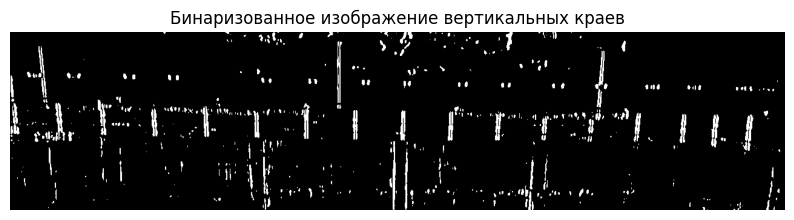

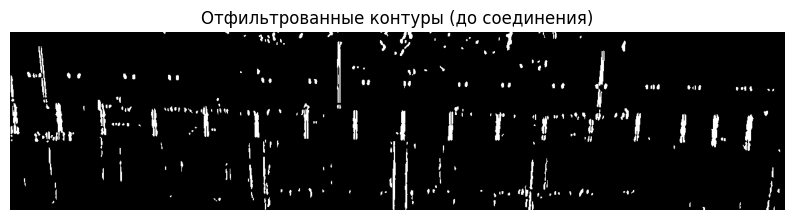

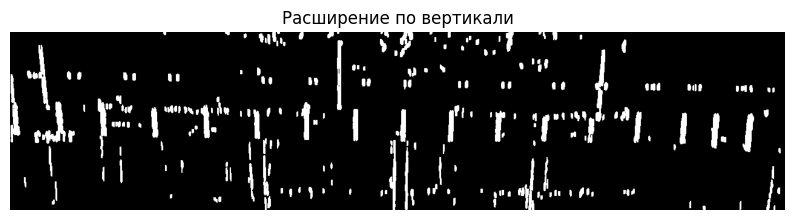

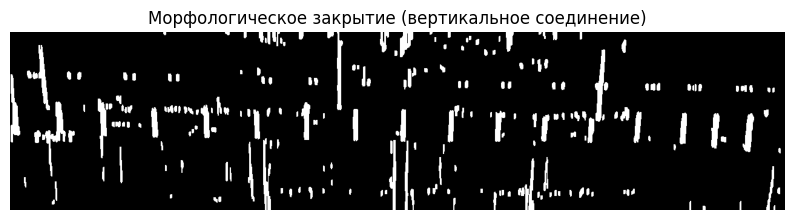

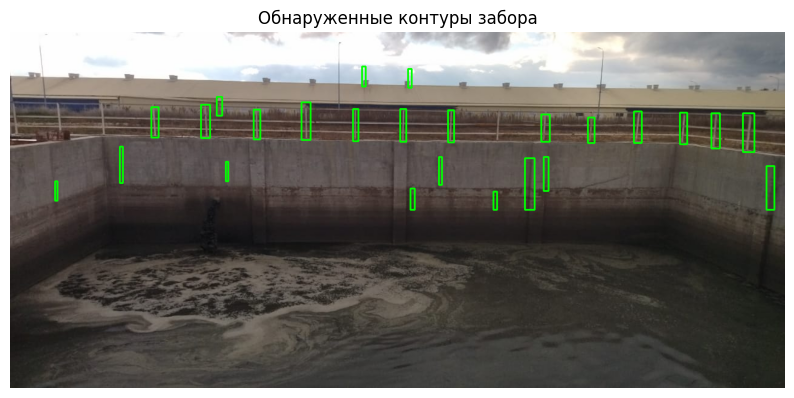

Нижняя граница забора на высоте: 206 пикселей
Обработка изображения: 2.jpg


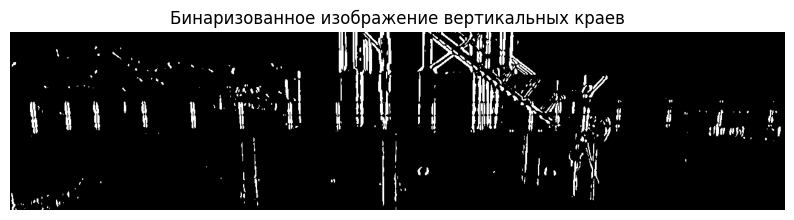

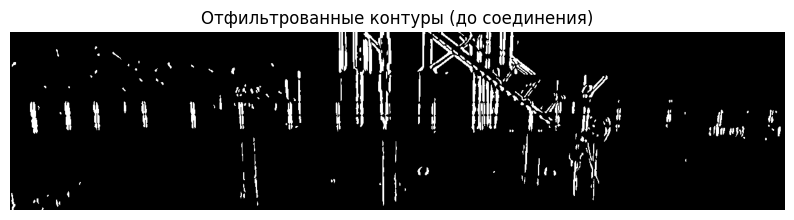

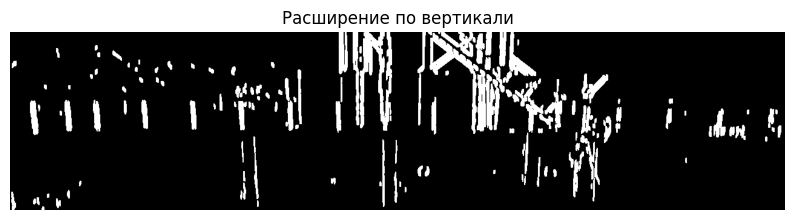

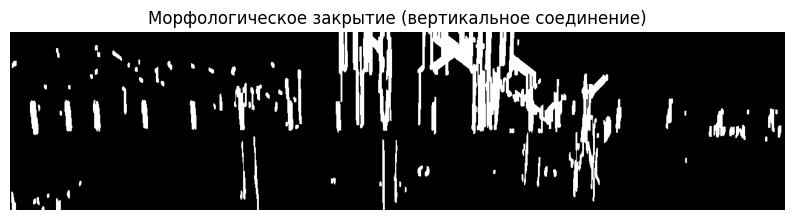

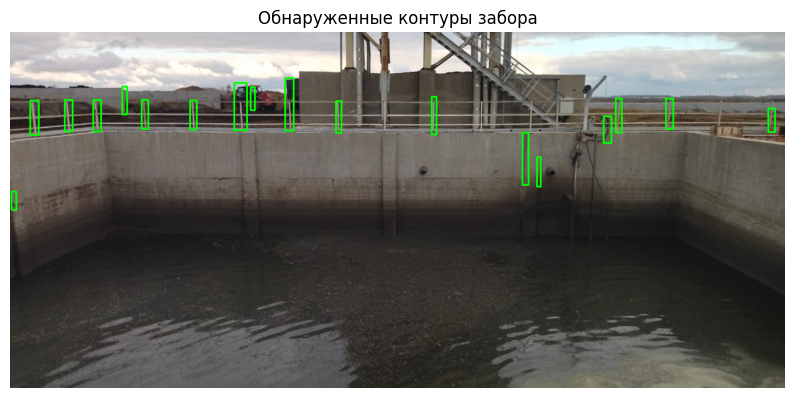

Нижняя граница забора на высоте: 179 пикселей
Обработка изображения: 3.jpg


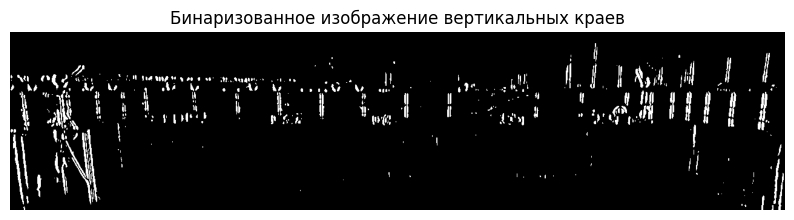

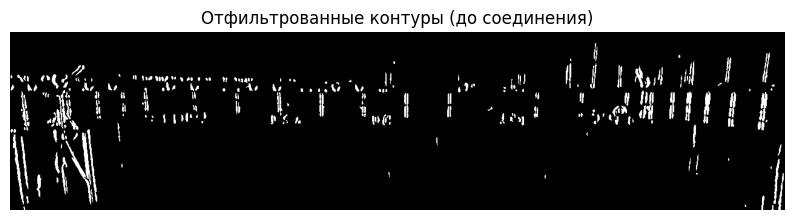

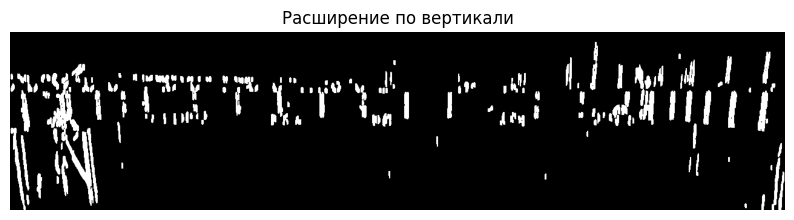

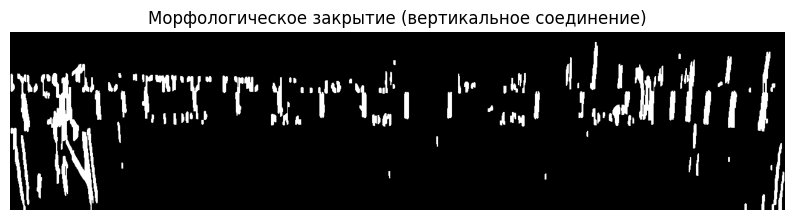

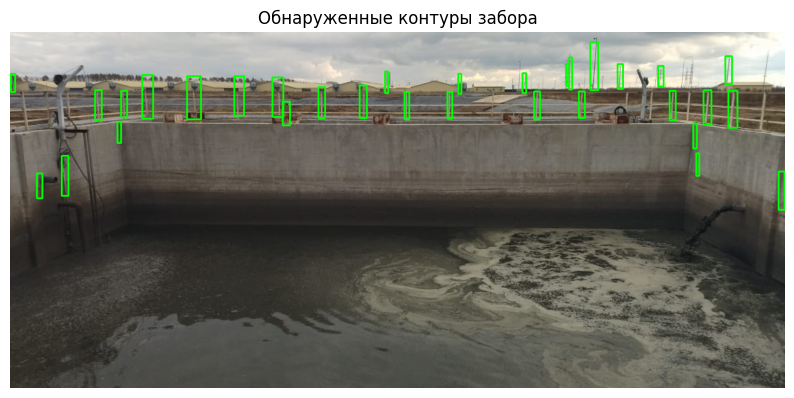

Нижняя граница забора на высоте: 148 пикселей
Обработка изображения: 4.jpg


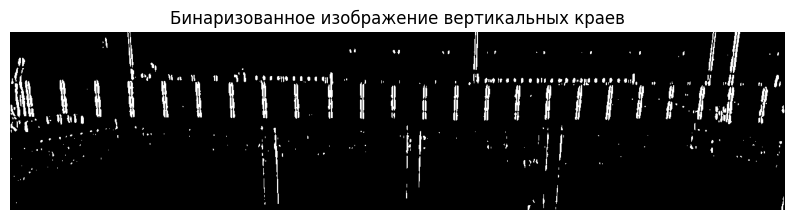

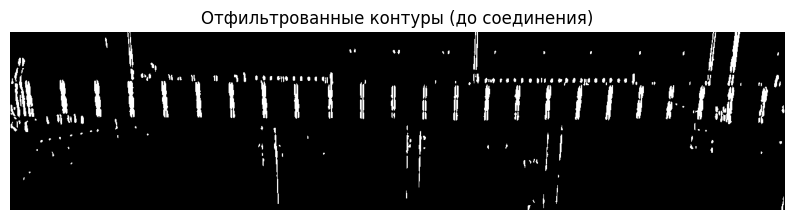

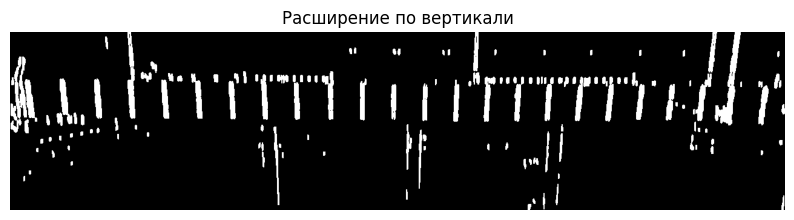

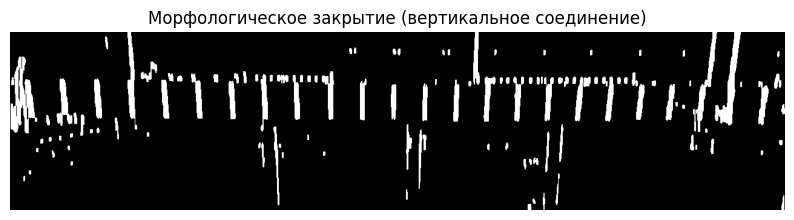

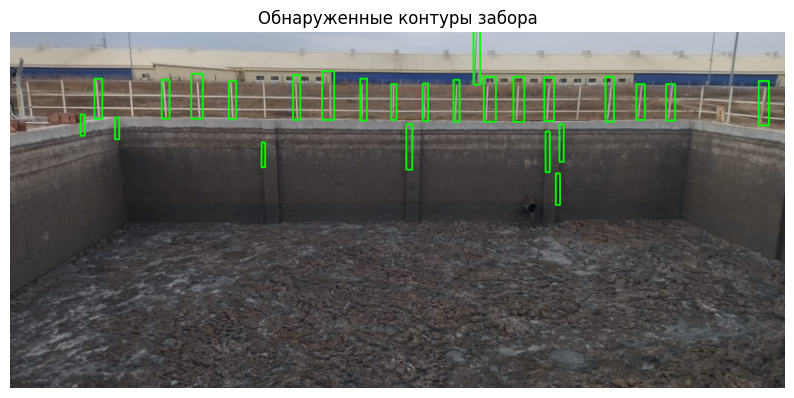

Нижняя граница забора на высоте: 165 пикселей
Обработка изображения: 5.jpg


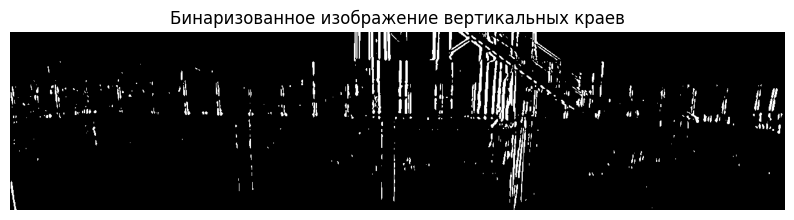

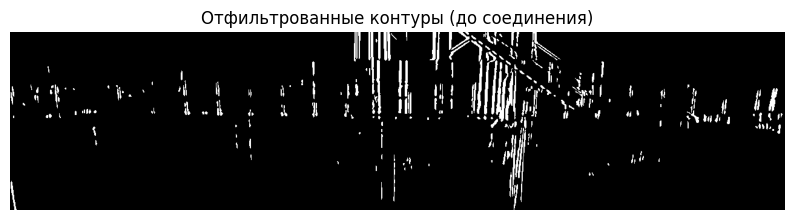

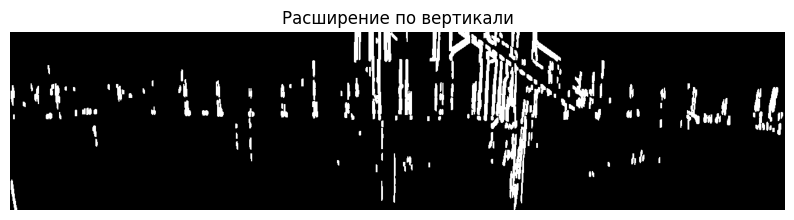

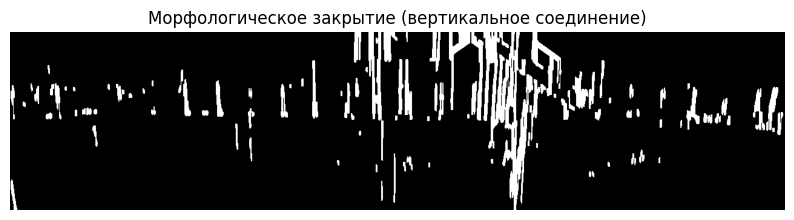

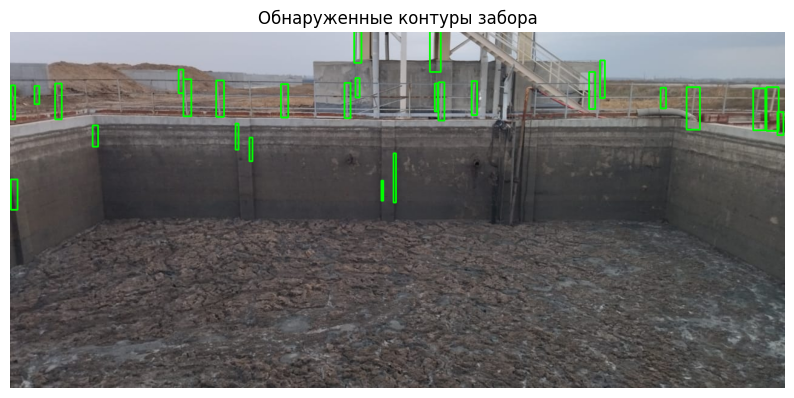

Нижняя граница забора на высоте: 155 пикселей
Обработка изображения: 6.jpg


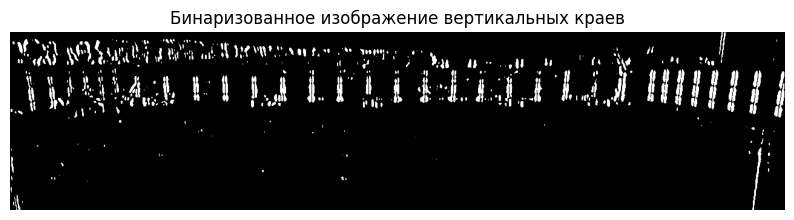

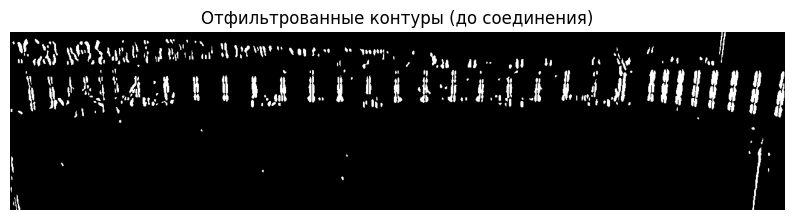

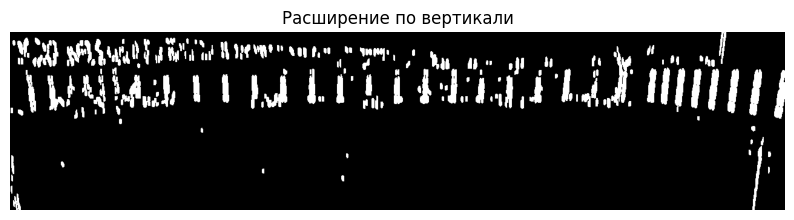

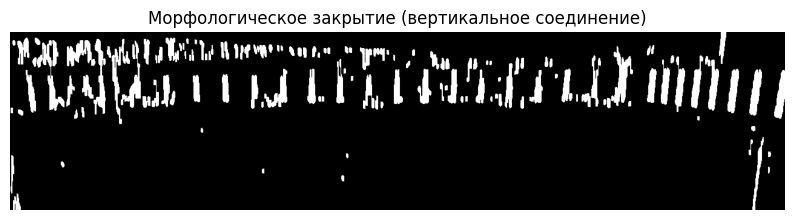

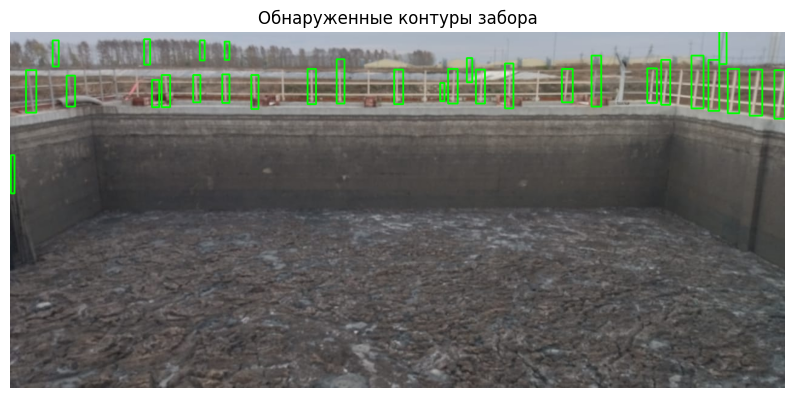

Нижняя граница забора на высоте: 115 пикселей
Обработка изображения: 7.jpg


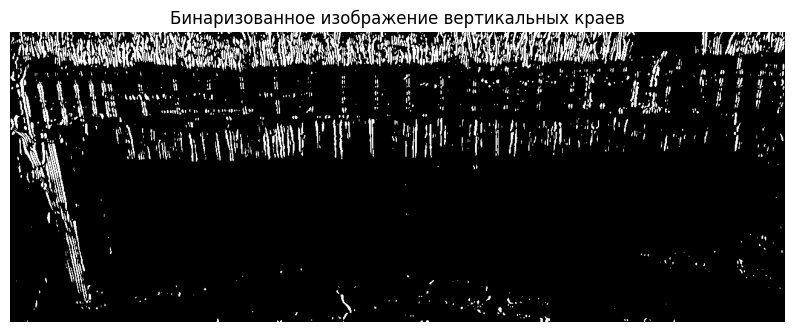

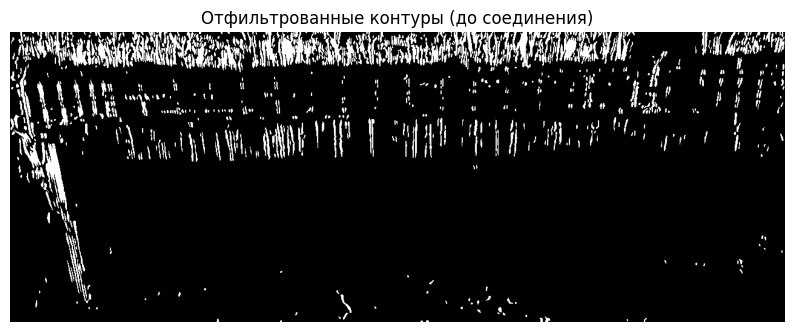

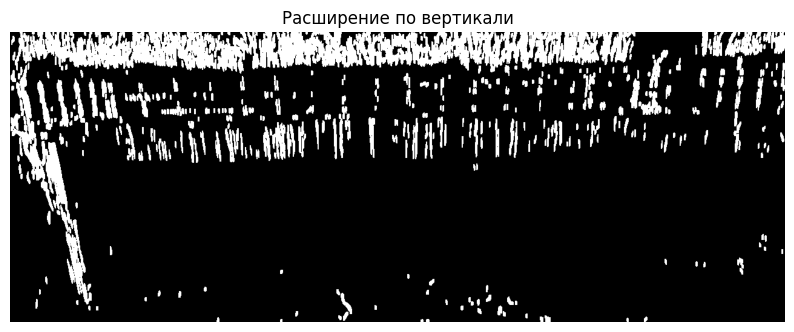

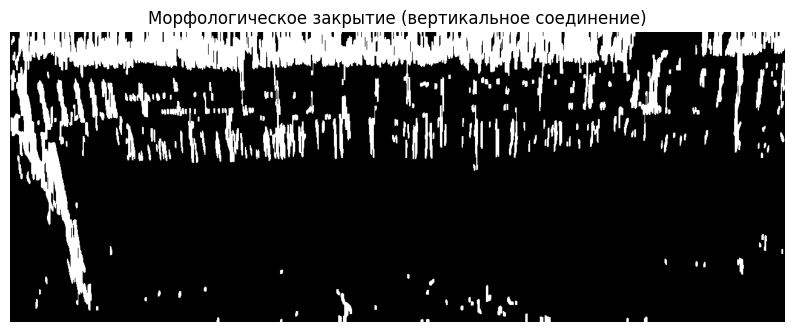

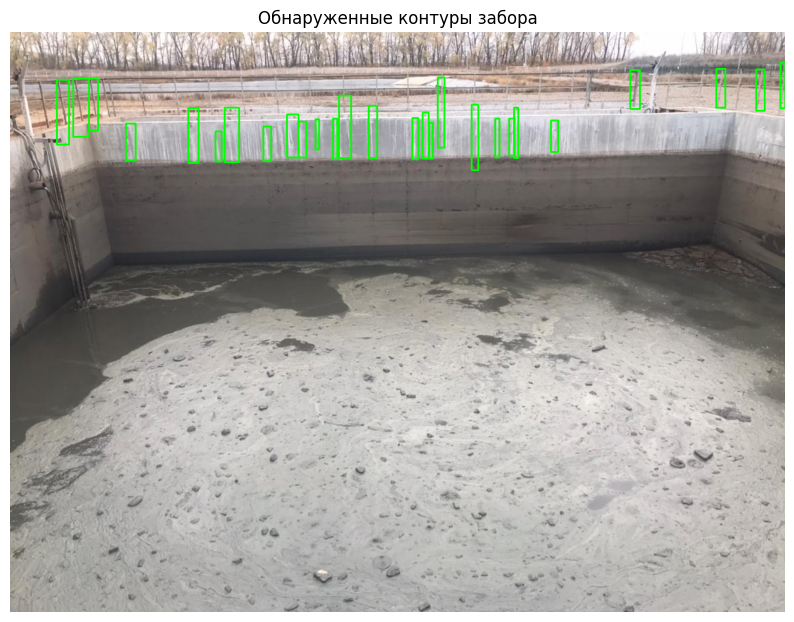

Нижняя граница забора на высоте: 193 пикселей
Обработка изображения: 8.jpg


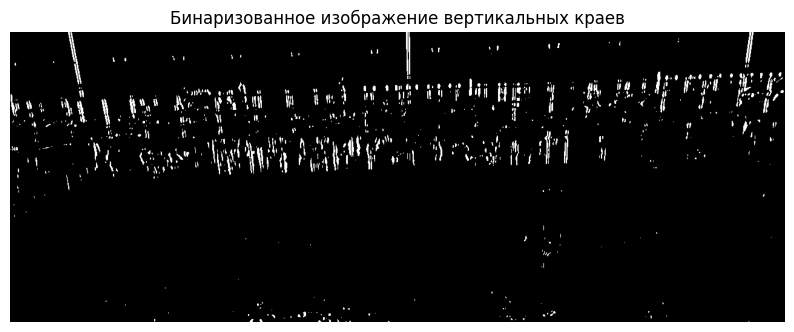

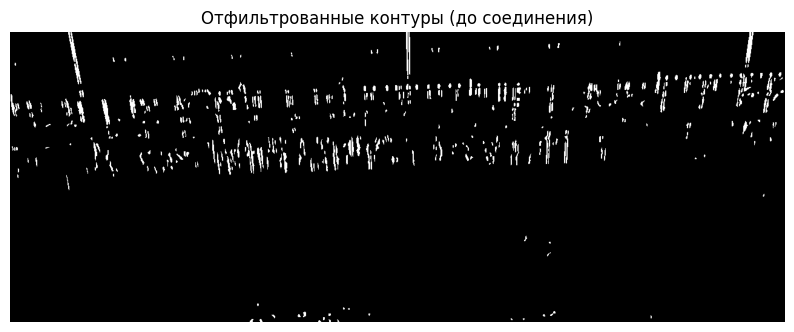

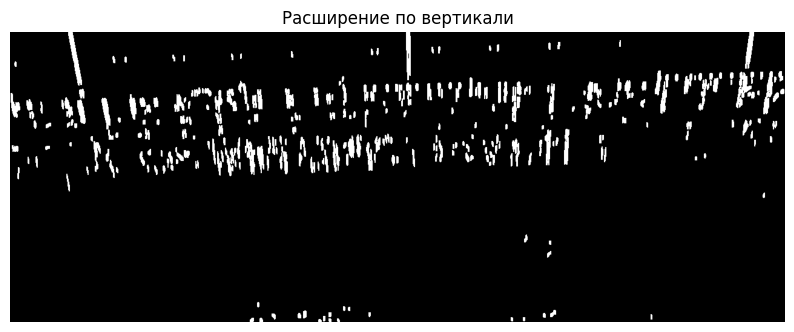

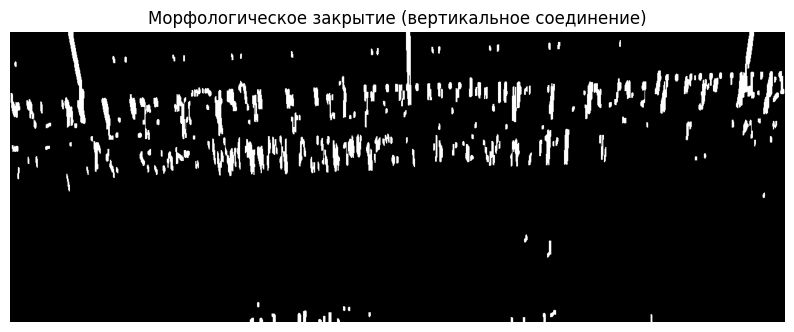

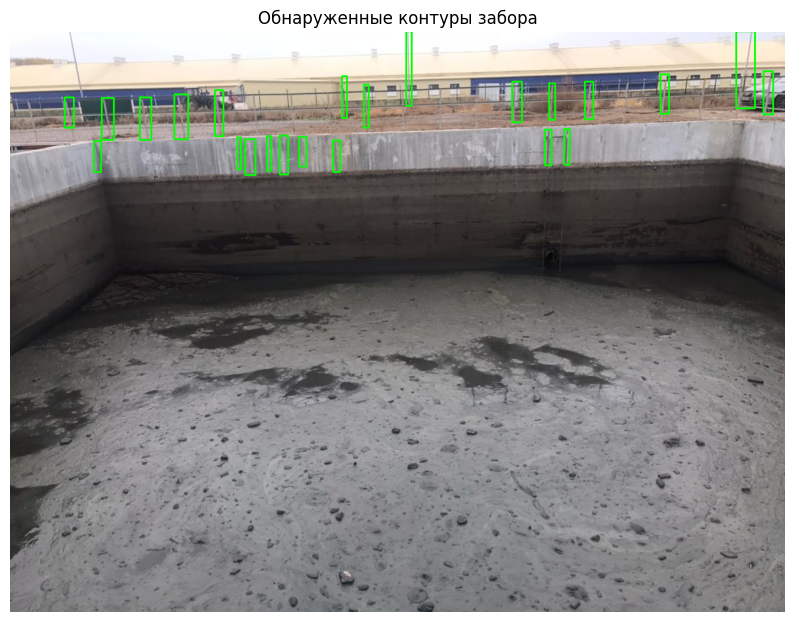

Нижняя граница забора на высоте: 182 пикселей
Обработка изображения: 9.jpg


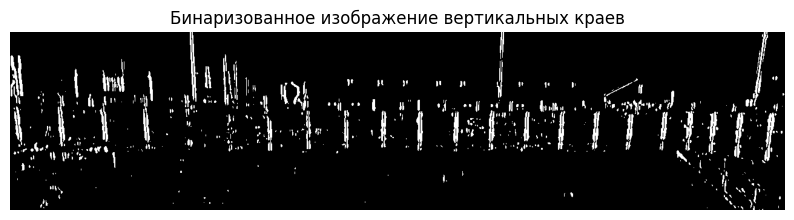

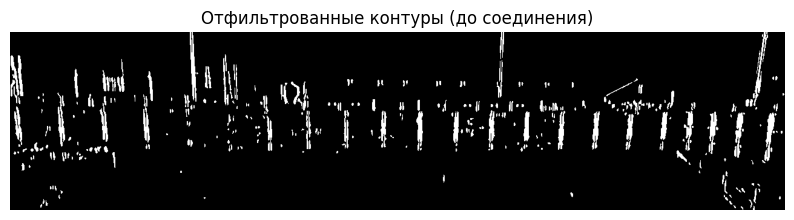

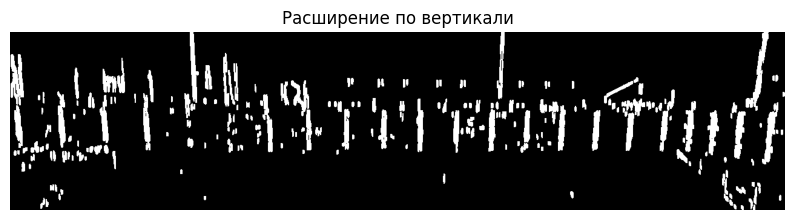

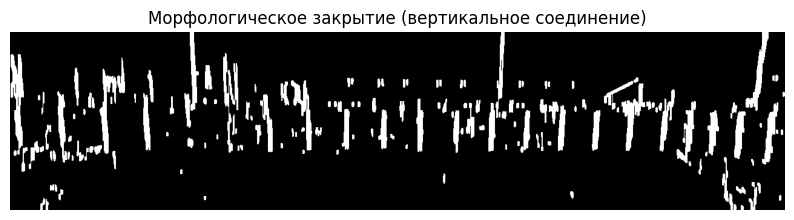

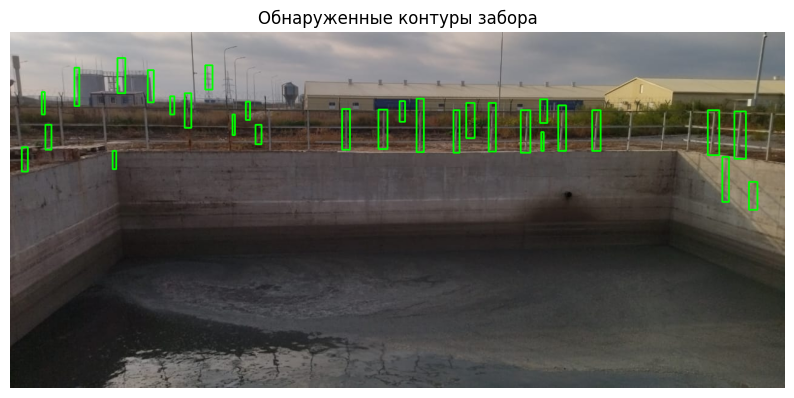

Нижняя граница забора на высоте: 181 пикселей


In [74]:
# Обработка каждого изображения
for idx, image in enumerate(images):
    print(f'Обработка изображения: {filenames[idx]}')
    
    original_image = image.copy()
    
    # Отображение исходного изображения
    #show_image('Исходное изображение', cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

    height, width = image.shape[:2]
    crop_height = height // 2
    image = image[:crop_height, :]
    
    # Предварительная обработка (без размытия)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_eq = clahe.apply(L)
    lab_eq = cv2.merge((L_eq, A, B))
    image_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    #show_image('После выравнивания гистограммы', cv2.cvtColor(image_eq, cv2.COLOR_BGR2RGB))
    
    # Преобразование в оттенки серого
    gray = cv2.cvtColor(image_eq, cv2.COLOR_BGR2GRAY)
    #show_image('Оттенки серого', gray, cmap='gray')

    # Обновленный код для обнаружения забора
    # Используем вертикальный оператор Собеля
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Бинаризация изображения
    _, thresh = cv2.threshold(scaled_sobel, 50, 255, cv2.THRESH_BINARY)
    show_image('Бинаризованное изображение вертикальных краев', thresh, cmap='gray')

    # Убираем очень маленькие контуры (точки) до соединения контуров
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Фильтрация контуров по площади
    min_contour_area = 3
    filtered_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area >= min_contour_area:
            filtered_contours.append(cnt)

    # Создаем новое бинарное изображение с отфильтрованными контурами
    filtered_binary = np.zeros_like(thresh)
    cv2.drawContours(filtered_binary, filtered_contours, -1, 255, thickness=cv2.FILLED)
    show_image('Отфильтрованные контуры (до соединения)', filtered_binary, cmap='gray')

    # **Расширяем контуры по вертикали**, чтобы захватить полную высоту забора
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 5))  # Вертикальное ядро
    dilated = cv2.dilate(filtered_binary, vertical_kernel, iterations=1)
    show_image('Расширение по вертикали', dilated, cmap='gray')

    # **Соединяем вертикальные контуры** с помощью морфологического закрытия с вертикальным ядром
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    morph = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, vertical_kernel, iterations=1)
    show_image('Морфологическое закрытие (вертикальное соединение)', morph, cmap='gray')

    # Поиск контуров после соединения
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Фильтрация контуров по размеру и соотношению сторон
    min_height = 0.05 * original_image.shape[0]
    max_height = 0.15 * original_image.shape[0]
    min_aspect_ratio = 3  # Высота должна быть как минимум в 5 раз больше ширины

    fence_bottoms = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = h / w if w != 0 else 0
        if h > min_height and h < max_height and aspect_ratio > min_aspect_ratio:
            fence_bottoms.append(y + h)
            cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    show_image('Обнаруженные контуры забора', cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

    if len(fence_bottoms) >= 5:
        fence_bottom = int(np.mean(fence_bottoms))
        cv2.line(original_image, (0, fence_bottom), (image.shape[1], fence_bottom), (255, 255, 0), 2)
        print(f'Нижняя граница забора на высоте: {fence_bottom} пикселей')
    else:
        print('Не удалось обнаружить забор на изображении.')
        continue